# Jobs data analysis: did you just get punk’d?

## Data From Kaggle


I downloaded the data from kaggle, which, as we all know has a bunch of different fun datasets. I picked the fake job analysis because I wanted to work with **imbalanced classification** problem. Detecting spam emails, jobs, hotel listings, are a few examples of imbalanced classification. Another example, more commonly seen in causal inference, is **detecting a rare disease**, though it is a bit different conceptually from the former examples. I will briefly explain later why. 


In [2]:
{
    "tags": [
        "hide_input",
    ]
}
import os
from scipy.stats import bernoulli, binom, poisson
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler,SMOTE
from numpy import genfromtxt
from plotnine import *
from sklearn import metrics
from imblearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
import re
import scipy.stats
import math
import statsmodels.stats.proportion
import sklearn.metrics 
from sklearn.metrics import make_scorer
import sklearn.impute
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import seaborn as sns
import json
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, precision_score, recall_score,fbeta_score, confusion_matrix, roc_auc_score, classification_report
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler
from numpy import genfromtxt
from plotnine import *
from sklearn import metrics
from imblearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_file, show
from bokeh.models import CheckboxButtonGroup, CheckboxGroup
from bokeh.models import RadioGroup
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import ppscore as pps
import warnings
warnings.filterwarnings(action='once')

## Importing and Cleaning Data


In [3]:
dat = pd.read_csv("fake_job_postings.csv", encoding='utf8')

#remove this alter
dat = dat.sample(n = 5000, axis = 0)

##INVESTIGATE
dat.shape

(5000, 18)

So we 17880 job reviews, with 17 features, the last column being whether the job was fraud or not.

In [4]:
print(dat.head(2))

      job_id                       title              location  \
8171    8172              Sales Director  US, PA, Philadelphia   
1047    1048  Linux Server Administrator        IN, MP, Indore   

                 department   salary_range  \
8171                    NaN    60000-90000   
1047  Server Administration  180000-240000   

                                        company_profile  \
8171  We launched Involvio as students at Drexel Uni...   
1047  Being into the IT domain for over 4 years, Wal...   

                                            description  \
8171  Come be one of the charter members of our sale...   
1047  Installation of all Unix, Linux.Source code an...   

                                           requirements  \
8171  4-year degree5+ years of successful performanc...   
1047  Expertise in C,C++ Language.Should be able to ...   

                                               benefits  telecommuting  \
8171  Cool old city officesCompetitive salary and st..

Among the 17 features:
<br>
- Three of them are binary: Does the job have a company logo? does the job poster have questions for candidate? does the job require telecommuting? 
- The *job_id* is the index column.
- Rest of the columns are strings. 
- A lot of the columns have missing values.
- The last column denotes 1 for a spam job, and 0 for real.
<br>
<br>
To clean the data, I drop the job_id, department, and salary range column, since they have too many NAs. A simple data visualisation will show that these columns are identically distributed across fraudulent and non fraudulent jobs.

<br>
Since the binary columns have no null valus, I replace all nan's in the string columns with **0**. We will see later how this does not affect/skew the data. (Note: doesn't need to be zero, can be any other number)

## Features

At first glance it might seem worth it to inspect the 'description' column. I added a new feature: the number of words for every description. 

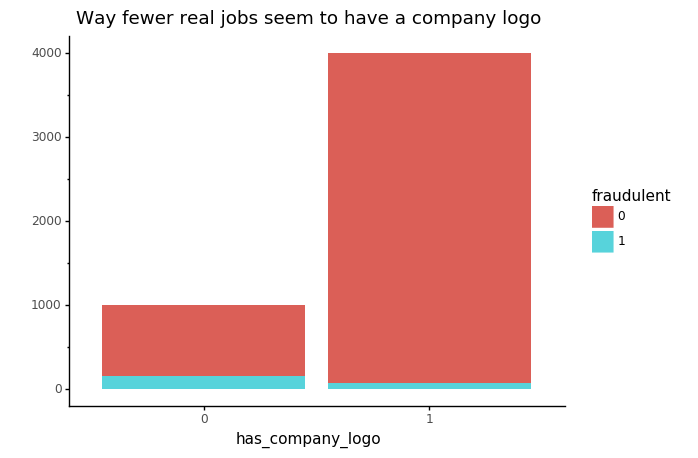

<ggplot: (274444201)>

In [5]:
dat.describe()
%matplotlib inline


##change encoding
def change_encode(column):
    return column.values.astype('U')

dat.apply(change_encode, axis = 0)

numeric_cols = dat.select_dtypes(include = "number").astype("object")

(
 ggplot(numeric_cols.drop("job_id", axis = 1), aes(fill = "fraudulent", x = "has_company_logo")) +
     geom_bar() + theme_classic() + labs(title = 'Way fewer real jobs seem to have a company logo', y = " ")
)

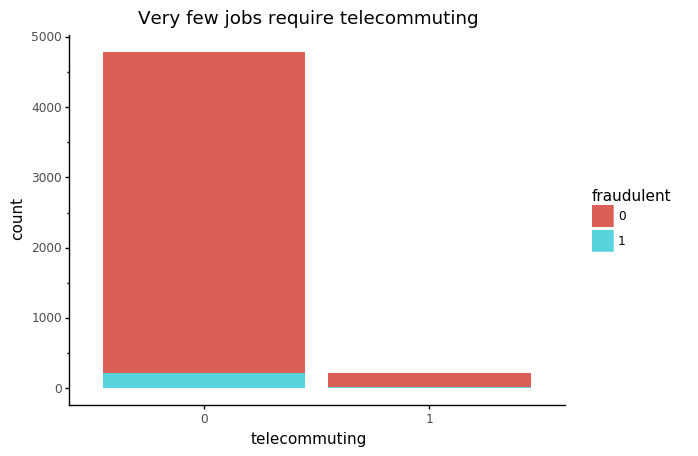

<ggplot: (7057184533)>

In [6]:
(
 ggplot(numeric_cols.drop("job_id", axis = 1), aes(fill = "fraudulent", x = "telecommuting")) +
     geom_bar() + labs(title = "Very few jobs require telecommuting") + theme_classic()
     )

In [37]:
clean_dat = dat.drop(['department', 'salary_range', 'job_id'], axis = 1)

clean_dat.fillna(0)

clean_dat = clean_dat.astype("object")
clean_dat["n_words"] = [len(x.split()) for x in dat.description.values.astype("U")]

(
 ggplot(clean_dat, aes(x = 'n_words', fill = 'fraudulent')) +
 geom_histogram(position = 'dodge') + theme_classic()
 )
clean_dat.shape

(5000, 16)

,n_words
count,5000.000000
mean,169.230000
std,124.791191
min,1.000000
25%,86.000000
50%,144.000000
75%,219.250000
max,2115.000000


The distribition of the number of words per job description seems pretty similarly distributed for fraud and non fraud jobs. This gives us the indication that we now have to rely on NLP for feature attraction.
<br>
Before doing that, remember that this is a imbalanced classification problem. Which means that even without using any sort of a model, if we pick a job at random and classify it as real, we still have a very high accuracy rate. This is called the **natural accuracy**.
<br>
Therefore, whatever model we choose, we must have a higher accuracy rate than the natural accuracy, although accuracy is **not** the metric for model selection in a imbalanced problem. More on this later.

In [8]:
##NATURAL ACCURACY

y = dat.fraudulent

# Count the total number of real jobs
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

# Calculate the percentage of real jobs
percentage = (float(count_non_fraud)/float(len(y))) * 100

# This is the "Natural Accuracy"
print("The natural accuracy rate is ", round(percentage, 3),". This means that if we randomnly classify a job as real, we will be correct roughly 95 out of 100 times.")

The natural accuracy rate is  95.42 . This means that if we randomnly classify a job as real, we will be correct roughly 95 out of 100 times.


## Word Clouds
<br>
When it comes to text, word clouds can be really useful to see the general distribution of words. The module `wordcloud` provides a very user friendly approach to create wordclouds. I decided to make this interactive: you can choose the feature to select the word cloud. 

There are 6032657 words in this column.


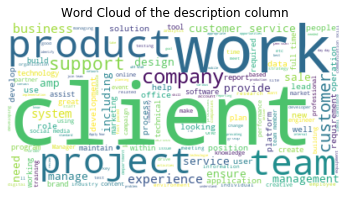

There are 3002028 words in this column.


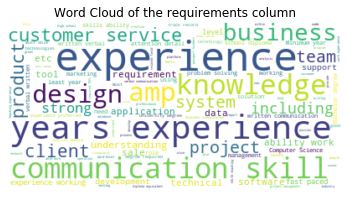

There are 49166 words in this column.


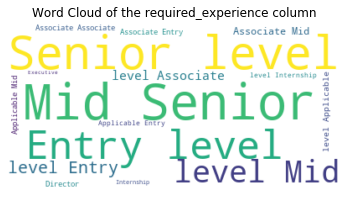

There are 3150563 words in this column.


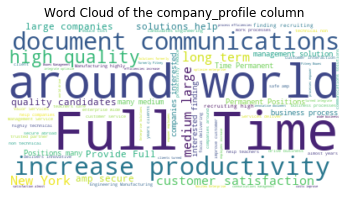

In [9]:
stop_words_wc = STOPWORDS
custom_stopwords = ['will', 'job', 'jobs', 'opportunity', 'nan', 'us', 'we', 'to']

for word in custom_stopwords:
     stop_words_wc.add(word)
     

def generate_wordcloud(column_name):
    
    text = " ".join(str(desc) for desc in dat[column_name])
    
    
    print ("There are {} words in this column.".format(len(text)))
    
    my_wc = WordCloud(stopwords = stop_words_wc, background_color = 'white').generate(text)
    
    plt.imshow(my_wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.title("Word Cloud of the {} column".format(column_name))
    plt.show()
    
##make this into plotly
generate_wordcloud("description")
generate_wordcloud('requirements')
generate_wordcloud('required_experience')
generate_wordcloud('company_profile')

## Extracting Features from Text
<br>
Apart from the binary features, the rest are textual. There is where NLP comes into play. Here I adopt two approaches to extract data:
<br>
<b>1.</b> Term Frequency - Inverse Document Frequency (TFIDF) <br>
<b>2.</b>  Bag-of-words Approach

<br>
<br>
The initial steps for these two approaches is the same.
<br>
1. Tokenization: Should we consider single worlds, pairs of words, triplets of words?
<br>
2. Remove all stopwords: Include personalised stopwords related to the analysis, maube like 'job', 'opportunity', etc.
<br>
3. Stem your words: This is commonly done to classify words that come from the same family into a common category, e.g, run, running, ran will all belong to the common category 'run'.
<br>
The module `nltk` is very useful for these prelim steps.
<br>


## Creating TFIDF vectors
<br>
Using `sklearn.feature_extraction` module, we can get both Tfidf and Bag of words vectorizer. Following is the code to obtain the features. If you have multiple text columns, it is usually a good idea to modularise this.
<br>
I used the PorterStemmer from `nltk.stem` to stem the words after removing the stopwords.
<br>
As noted before, the three binary features remain as is. 
<br>
Additionally, for both TFIDF and BoG words approach, I use single and double words token. This mean that first all single words will be considered, and then all pairs of consecutive words will be considered. To know more about *n-grams*, check out: https://en.wikipedia.org/wiki/N-gram

<br>
TFIDF is a text feature exxtraction technique that weighs a word's (or a pair of consecutive words') frequency (TF) and its inverse document frequency (IDF).  IDF is simply measure of how significant the word (or pair of consecutive words) is in the entire collection of texts. The product of the TF and IDF scores of a term is called the TFIDF score. 

The higher the TFIDF score (weight), the rarer the term and vice versa. Therefore, TFIDF automatically gives really low weights to STOPWORDS so we can possibly avoid the step of removing them. Regardless, I disregard stopwords.
<br>

A useful argument is max_features in both approaches: we can set a limit to how many most important (or high scoring) words/ pairs of words we want to include.

Notice that I have set the ngram_range from (1, 2), means unigrams and bigrams. Except for the *description* and *requirements* column, I have set the rest of the max_frequencies to 5. This is because, upon inspection, it was evident that these columns contained only a couple of words or so for each observation. 


In [57]:
porter = PorterStemmer()
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    #token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(str(word)))
        stem_sentence.append(" ")
        
    
    text = "".join(stem_sentence)
    
    text = re.sub(r'[^a-zA-Z]', ' ', text) #remove puncation
    text = " ".join(text.split())#remove extra spaces
    
    final_token = word_tokenize(text)
    
    stop = set(stopwords.words('english'))
    stop_free = " ".join([word for word in final_token 
               if((word not in stop) and (not word.isdigit()))])
    
    return stop_free

####
     

def get_tfidf(column, max_feats):
    hehe = [stemSentence(x) for x in clean_dat[column].values.astype("U")]
    ##create tfidf vectoriser
    
    tfidf = TfidfVectorizer(max_features = max_feats,ngram_range=(1,2)).fit(hehe)
    X = tfidf.transform(hehe)
    X_df = pd.DataFrame(X.toarray(), columns = tfidf.get_feature_names())
    return X_df

###

desc = get_tfidf("description", 5000)
req = get_tfidf("requirements", 5000)
title = get_tfidf("title", 5)

loc = get_tfidf("location", 5)


company_profile = get_tfidf("company_profile", 5)

emp_type = get_tfidf("employment_type", 5)

##huh 

logo_ques = numeric_cols.drop(["job_id", "fraudulent"], axis = 1)
n_words = clean_dat.n_words

##

req_exp = get_tfidf("required_experience",5)
req_ed = get_tfidf("required_education", 5)
ind = get_tfidf("industry", 5)
func = get_tfidf("function", 5)

feat_list_tfidf = [desc, req, title, loc,
              company_profile, logo_ques, emp_type, req_exp,
             req_ed, ind, func, n_words]
feat_df_tfidf = pd.concat([desc, req, title, loc,  
                         company_profile, logo_ques, emp_type, req_exp,
             req_ed, ind, func, n_words], axis = 1)
feat_names_tfidf = feat_df_tfidf.columns
feat_mat_tfidf = feat_df_tfidf.values





In [60]:
pd.concat(feat_list_tfidf, axis = 0)

,aa,aa de,aa phone,aabbf,aabbf ca,aan,ab,ab ea,ab ff,abc,...,youth,youtub,yr,zealand,zend,zendesk,zero,zijn,zone,0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171.0
383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0
7860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,279.0
2153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0


## Bag Of Words Approach
<br>
As an alternative, I created a bag-of-word matrix. This approach is pretty straightforward. For info, see here: https://en.wikipedia.org/wiki/Bag-of-words_model. The code is not that different from the TFIDF approach:

In [11]:
##create a function that takes in a column, inspects individual review, breaks down sentence into words, stems it, removes stop words, and returns the sentence and the invidual review.
porter = PorterStemmer()
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    #token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(str(word)))
        stem_sentence.append(" ")
        
    
    text = "".join(stem_sentence)
    
    text = re.sub(r'[^a-zA-Z]', ' ', text) #remove puncation
    text = " ".join(text.split())#remove extra spaces
    
    final_token = word_tokenize(text)
    
    stop = set(stopwords.words('english'))
    stop_free = " ".join([word for word in final_token 
               if((word not in stop) and (not word.isdigit()))])
    
    return stop_free

####
     

def get_bog(column, max_feats):
    hehe = [stemSentence(x) for x in clean_dat[column].values.astype("U")]
    ##create tfidf vectoriser
    tfidf = CountVectorizer(max_features = max_feats, ngram_range = (1,2)).fit(hehe)
    X = tfidf.transform(hehe)
    X_df = pd.DataFrame(X.toarray(), columns = tfidf.get_feature_names())
    return X_df

###

desc = get_bog("description", 5000)
req = get_bog("requirements", 5000)
title = get_bog("title", 5)

loc = get_bog("location", 5)


company_profile = get_bog("company_profile", 5)

emp_type = get_bog("employment_type", 5)

##huh 

logo_ques = numeric_cols.drop(["job_id", "fraudulent"], axis = 1)
n_words = clean_dat.n_words

##

req_exp = get_bog("required_experience", 5)
req_ed = get_bog("required_education", 5)
ind = get_bog("industry", 5)
func = get_bog("function", 5)

feat_list_bog = [desc, req, title, loc,
              company_profile, logo_ques, emp_type, req_exp,
             req_ed, ind, func, n_words]
feat_df_bog = pd.concat([desc, req, title, loc,  
                         company_profile, logo_ques, emp_type, req_exp,
             req_ed, ind, func, n_words], axis = 1)
feat_names_bog = feat_df_bog.columns
feat_mat_bog = feat_df_bog.values

In [16]:
feat_df_bog.shape

(8594, 10044)

# Prediction

Now that we have our features ready, we can fit the models. I decided to use Gradient Boosting (ADA boost) and RandomForest, two very popular ensemble methods for NLP. I show the steps for GBoost, but i'll show the results for both methods. 

## Preprocessing

### Normalize

Since this is supervised learning, it is generally good practice to normalise the data (as opposed to standarizing). If the distribution is not Gaussian or the standard deviation is very small, the normalizing works better, even though  tree-based ensemble methods such Random Forest are invariant to feature scaling. Nevertheless, it still it might be a good idea to rescale the data.
<br>


In [27]:
min_max_scaler = preprocessing.MinMaxScaler()
xx = min_max_scaler.fit_transform(feat_mat_tfidf)

## response variable

y = clean_dat["fraudulent"].values



In [36]:
xx.shape
#y.shape

(8594, 10044)

In [28]:
xtrain, xtest, ytrain, ytest = train_test_split(xx, y, test_size = 0.25, stratify = y, random_state = 25)

ValueError: Found input variables with inconsistent numbers of samples: [8594, 5000]

## Model Selection

Next to do is get the best hyperparameters for gradient boosting. The most important hyperparameters for gradient boosting are:
- Number of estimators
- Maximum depth of tree
- Learning Rate
- Maximum features to use at every split

Instead of a gridsearch, I decided to use random search techniqque for hyperparameter tuning since its computationally more efficient. If you have a more powerful computer (or just generally more time), try to validate the results of random search with those of grid search. 


In [ ]:
##SET THE GRID.
param_grid_gb = {
    'learning_rate': [0.0001, 0.001, 0.1, 1, 10],
    'max_features': ['sqrt', 'log2'],
    'subsample': [0.8, 0.9, 1],
    'n_estimators': [2000, 3500, 5000],
    'max_depth': np.arange(6, 30, 3)
    
    }
##

Note that setting loss = 'exponential' as an argument in GradientBoostingClassifier will then imply ADA boosting. More on that here: https://stats.stackexchange.com/questions/430158/is-exponential-loss-function-the-only-reason-for-adaboost-being-adaptive-algorit. Also, the subsample parameter of less than 1 implies sequential boosting.

The reason we shouldn't choose accuracy as the metric for model selection in class imbalance problem is quite evident. As seen previously, because of such few job emails, classifying them incorrectly will not lead to a substantial decrease in accuracy.
For such problems, we might want to look at precision. This is because while it is not that dangerous to label a fraud job as real, it is quite costly to label a real job as fake. Therefore, we're sort of okay with labelling a positive case as negative (false negative) but not okay with labelling a negative case as positive (false positive). So we minimise false positive cases. Hence, we maximise **precision**.
<br>
In other imbalanced cases, for example, classifying a rare disease, the opposite holds: its less dangerous to label a healthy patient as having the disease, than to label an unhealthy patient as healthy. Here, we're sort of okay with labelling a negative case as positive as opposed to a positive case as negative. So we minimise false negatives. Hence, we maximise **recall**.

There is always a trade-off between precision and recall. 

In this case, we maximise **f1** metric in the randomised search function. This is the harmonic mean of recall and precision. But since we are a little more concerned with maximizing precision, we can make it so that is has more weight. using **make_scorer** - this is called the fbeta score. Check this page out for a great explanation: https://machinelearningmastery.com/fbeta-measure-for-machine-learning/

You can access all the available scoring metrics by typing in ` sorted(sklearn.metrics.SCORERS.keys())` in the console.

As you can see, this classifier is doing a pretty good job. We can create the same model for the Bag Of Words approach matrix. I've shown the confusion matrix for that model too.

In [ ]:
##xgboost

gmb0 = GradientBoostingClassifier(random_state = 25, loss = 'exponential')

f1_weighted = make_scorer(fbeta_score, beta = 0.5)

rand_search_model_gb = RandomizedSearchCV(gmb0, 
                            param_grid_gb, 
                            scoring=f1_weighted, n_jobs = 2, refit = True, cv = 5)

rand_search_model_gb.fit(xtrain, ytrain)

f1_pred_gb = rand_search_model_gb.predict(xtest)
confusion_matrix(ytest, f1_pred_gb)




In [ ]:
##random forest for tfidf
param_grid_rf = {
    'min_samples_split':[2,5,10,30,100],
    'min_samples_leaf':[1,2,5,10],
    'n_estimators': [100, 300, 700, 1000], ##fewer than gboost bcz overfitting
    'max_depth': np.arange(6, 30, 3),
     'max_features': ['sqrt', 'log2']
    
    }
rf0 = RandomForestClassifier(random_state = 25, class_weight = 'balanced')

f1_weighted = make_scorer(fbeta_score, beta = 0.5)

rand_search_model_rf = RandomizedSearchCV(rf0, 
                            param_grid_rf, 
                            scoring=f1_weighted, n_jobs = 2, refit = True, cv = 5)

rand_search_model_rf.fit(xtrain, ytrain)
f1_pred_rf = rand_search_model_rf.predict(xtest)
confusion_matrix(ytest, f1_pred_rf)


## Feature Importance

Both gradient boosting and random forests have feature_importances columns. We can take a look at what the top words and phrases are when it comes to detecting fraudulent emails.

In [ ]:
best_rf = RandomForestClassifier(random_state = 25, n_estimators = 100,
                                 min_samples_split = 5,
                                 min_samples_leaf = 1,
                                 max_features = 'sqrt',
                                 max_depth = 24)
best_rf.fit(xtrain, ytrain)

ins =  best_rf.feature_importances_

is_this = pd.DataFrame({'names': np.array(feat_df_tfidf.columns), 'imp':ins}, columns = ['names', 'imp'])

is_this = is_this.sort_values(by = 'imp', ascending = False)
non_zero = is_this[is_this['imp'] > 0]
non_zero.head(25)